# Background

The owner of a company would like to be able to predict whether employees will stay with the company or leave. 

## Data Description

The data contains information about various characteristics of employees. Please note that the dataset has been updated to account for repetitions, which is needed for Goodness of Fit Assessment. See below for the description of these characteristics. 

1. **Age_Group**: 1-9 (1 corresponds to teen, 2 corresponds to twenties, etc.) 
2. **Gender**: 1 if male, 0 if female 
3. **Tenure**: Number of years with the company 
4. **Num_Of_Products**: Number of products owned 
5. **Is_Active_Member**: 1 if active member, 0 if inactive member 
6. **Staying**: Fraction of employees that stayed with the company for a given set of predicting variables.

## Setup

You can import the data and set up the problem with the following R code:

In [1]:
import pandas as pd
import numpy as np
import pylab
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import glm
from scipy.stats import chi2, norm
from statsmodels import graphics

In [2]:
# Import the data
rawdata = pd.read_csv("employee_data.csv", header=0, encoding="utf-8")

# Create variable Staying
rawdata["Staying"] = rawdata["Stay"] / rawdata["Employees"]

# Set variables as categoricals
rawdata["Num_Of_Products"] = rawdata["Num_Of_Products"].astype("category")
rawdata["Age_Group"] = rawdata["Age_Group"].astype("category")
rawdata["Gender"] = rawdata["Gender"].astype("category")
rawdata["Is_Active_Member"] = rawdata["Is_Active_Member"].astype("category")

# Print head of data
rawdata.head()

,Age_Group,Gender,Tenure,Num_Of_Products,Is_Active_Member,Stay,Employees,Staying
0,2,1,3,1,0,5,11,0.454545
1,2,1,4,1,0,5,10,0.500000
2,2,1,4,1,1,2,13,0.153846
3,2,0,7,1,0,3,10,0.300000
4,2,1,7,1,0,2,14,0.142857


# Fitting a Model

Fit a logistic regression model using *Staying* as the response variable with *Num Of Products* as the predictor and logit as the link function.

In [3]:
model1 = glm(
    "Staying ~ Num_Of_Products",
    data=rawdata,
    family=sm.families.Binomial(),
    var_weights=np.asarray(rawdata["Employees"]),
).fit()
print(model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Staying   No. Observations:                  158
Model:                            GLM   Df Residuals:                      156
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1193.2
Date:                Sun, 08 Jan 2023   Deviance:                       632.04
Time:                        21:46:06   Pearson chi2:                     562.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.8902
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3789 

The Odds of Staying can be defined as $\frac{p_{staying}}{1-p_{staying}}$=$e^{\beta_0+\beta_1*X_{Num\_Of\_Products2}}$. After plugging in the numbers the odds of staying is $e^{0.3789-1.7668*Num\_Of\_Products2}$. When the employee owns 2 products then the log-odds decrease by 1.7668 compared to when the customer owns only 1 product. Similarly, when the employee owns 2 products the odds decrease by $\exp^{1.7668}$ = 5.85 compared to when the customer owns only 1 product.

# Inference

(a) Using model1, find a 90% confidence interval for the coefficient for *Num_Of_Products2*.

In [4]:
model1.conf_int(alpha=0.1, cols=None)

,0,1
Intercept,0.300849,0.456865
Num_Of_Products[T.2],-1.936460,-1.597195


In [5]:
chi_square = chi2.cdf(
    model1.null_deviance - model1.deviance, df=model1.null - model1.resid_pearson
)
print(f"p-value is {1-np.mean(chi_square[~np.isnan(chi_square)])}")

p-value is 0.0


Since model1's p-value is very close to zero, we can reject the null hypothesis that the slope coefficient is equal to zero and conclude that the model is significant overall.

In [6]:
print(f"left-sided p-value for intercept: {norm.cdf(model1.tvalues.iloc[0])}")
print(f"left-sided p-value for slope: {norm.cdf(model1.tvalues.iloc[1])}")

left-sided p-value for intercept: 0.9999999999999993
left-sided p-value for slope: 4.2695465759130517e-66


The p-value associated to the left-sided test for the slope is below 0.01, so we can reject the null hypothesis that $\beta_i\ge 0$ and conclude that the coefficient for Num_Of_Products is statistically negative at the 0.01 significance level.

# Goodness of fit

## Perform goodness-of-fit hypothesis tests using both Deviance and Pearson residuals.

In [7]:
gof_deviance_chi_square = chi2.cdf(model1.deviance, df=model1.df_resid)
print(f"Deviance residuals test p-value is {1-gof_deviance_chi_square}")

Deviance residuals test p-value is 0.0


In [8]:
gof_pearson_chi_square = chi2.cdf(
    np.sum(np.square(model1.resid_pearson)), df=model1.df_resid
)
print(f"Pearson residuals test p-value is {np.mean(1-gof_pearson_chi_square)}")

Pearson residuals test p-value is 0.0


The p-value is close to 0 using the Deviance and the Pearson test indicating that this model is not a good fit. In the statistical inference above the p-value is also close to 0 indicating that it is statistically significant thus has explanatory power. Since the p-value is close to 0 we can reject the Null hypothesis that the model is a good fit. It is possible for a model to have good explanatory power but be a bad fit.

## QQ plot and histogram of the deviance residuals.

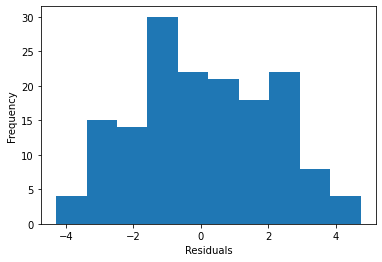

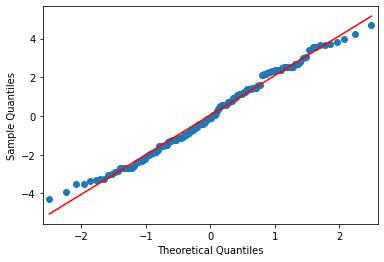

In [9]:
plt.hist(model1.resid_deviance)
plt.xlabel("Residuals")
plt.ylabel("Frequency")

graphics.gofplots.qqplot(model1.resid_deviance, line="r")
pylab.show()

The QQ Plot and histogram show that the residuals closely follow a normal distribution with some deviation at the tails. The plots look reasonable enough that they do not depart from a normal distribution.

## Calculate the estimated dispersion parameter for this model.

In [10]:
print(f"The dispersion parameter is {model1.deviance/model1.df_resid}")

The dispersion parameter is 4.051538680267789


The estimated dispersion parameter is larger than 2, so overdispersion is a concern for this model.

# Fitting the full model

Fit a logistic regression model using *Staying* as the response variable with *Age_Group*, *Gender*, *Tenure*, *Num_Of_Products*, and *Is_Active_Member* as the predictors and logit as the link function.

In [11]:
model2 = glm(
    "Staying ~ Age_Group + Gender + Tenure + Num_Of_Products + Is_Active_Member",
    data=rawdata,
    family=sm.families.Binomial(),
    var_weights=np.asarray(rawdata["Employees"]),
).fit()
print(model2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Staying   No. Observations:                  158
Model:                            GLM   Df Residuals:                      150
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -958.34
Date:                Sun, 08 Jan 2023   Deviance:                       162.35
Time:                        21:46:08   Pearson chi2:                     154.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9944
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.10

The probability of staying = $\frac{e^{-1.09572+0.384480Age.Group3+1.734115Age.Group4+2.955578Age.Group5-0.572069Gender1-0.003319Tenure-1.410946Num.Of.Products2-0.850280Is.Active.Member1}}{1+e^{-1.09572+0.384480Age.Group3+1.734115Age.Group4+2.955578Age.Group5-0.572069Gender1-0.003319Tenure-1.410946Num.Of.Products2-0.850280Is.Active.Member1}}$

*Tenure*:
- A one unit increase in *Tenure* decreases the odds of an employee staying with the company by 0.3% holding all other predictors constant. $1−e^{−0.003}=0.003$
- A one unit increase in *Tenure* changes the odds of an employee staying with the company by a factor of 0.997 holding all other predictors constant. $e^{−0.003}=0.997$

*Is_Active_Member1*:
- The odds of staying for an employee who is an active member(*Is_Active_Member1*) is 57.26% lower than that of an employee who is not an active member (*Is_Active_Member0*) holding all other predictors constant. $1−e^{−0.8502}=0.5726$
- The odds of staying for an employee who is an active member(*Is_Active_Member1*) change by a factor of 0.4273 relative to an employee ho is not an active member (*Is_Active_Member1*) holding all other predictors constant. $e^{−0.8502}=0.4273$

The Is.Active.Member1 variable is statistically significant with the other variables in model2 at the 0.01 significance level since the p-value is approximately 0.

## Has the goodness of fit been affected?

### Perform goodness-of-fit hypothesis tests using both Deviance and Pearson residuals.

In [12]:
gof2_deviance_chi_square = chi2.cdf(model2.deviance, df=model2.df_resid)
print(f"Deviance residuals test p-value is {1-gof2_deviance_chi_square}")
gof2_pearson_chi_square = chi2.cdf(
    np.sum(np.square(model2.resid_pearson)), df=model2.df_resid
)
print(f"Pearson residuals test p-value is {np.mean(1-gof2_pearson_chi_square)}")

Deviance residuals test p-value is 0.2319117818000821
Pearson residuals test p-value is 0.3912174065054784


Both the Deviance residuals and the Pearson residuals are large enough to fail to reject the Null hypothesis that the model is a good fit. With the added variables we may consider model2 a good fit for the data.

### Evaluate the linearity assumption of **model2** by plotting the log-odds of **Staying** vs. **Tenure**.

c:\Python39\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


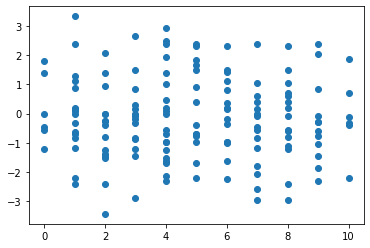

In [13]:
plt.scatter(rawdata["Tenure"], np.log(rawdata["Staying"] / (1 - rawdata["Staying"])))

The log odds of staying appear to be evenly spread across 0.The linearity assumption appears to hold.

### Evaluate whether the deviance residuals are normally distributed by producing a QQ plot and histogram of the deviance residuals.

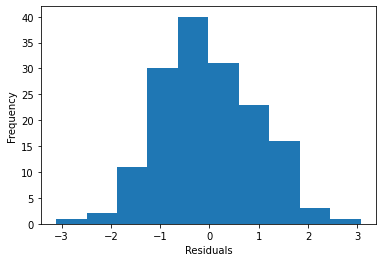

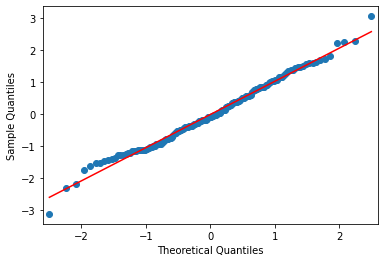

In [14]:
plt.hist(model2.resid_deviance)
plt.xlabel("Residuals")
plt.ylabel("Frequency")

graphics.gofplots.qqplot(model2.resid_deviance, line="r")
pylab.show()

There are some small departures from the normal line in the QQ Plot but not enough to determine that the residuals do not have a normal distribution

### Calculate the estimated dispersion parameter for this model.

In [15]:
print(f"The dispersion parameter is {model2.deviance/model2.df_resid}")

The dispersion parameter is 1.0823299400158772


The estimated dispersion parameter of 1.082 is less than 2 so model2 is not over dispersed.

Overall, I would say model2 is a good-fitting model as the assumptions appear to hold up. The linearity assumption of the Std. Residuals vs Tenure shows the Log Odds of staying evenly distributed around 0 for all Tenure years. Plotting the Logit of Staying vs each trial does not show any obvious patterns so the Independence assumption appears to hold.The QQ plot and histogram plot shows that the residuals are normally distributed.

A check for multicollinearity shows each variable close to 1 so there does not appear to be an issue with multicollinearity in model2.

The link function used for model2 is the logit function. Based on the reasons listed above model2 is considered a good-fitting model.

# Prediction

Suppose there is an employee with the following characteristics:

1. **Age_Group**: 2

2. **Gender**: 0

3. **Tenure**: 2

4. **Num_Of_Products**: 2

5. **Is_Active_Member**: 1

## Predict their probability of staying using model1.

In [16]:
test_data = pd.DataFrame(
    data={
        "Age_Group": 2,
        "Gender": 0,
        "Tenure": 2,
        "Num_Of_Products": 2,
        "Is_Active_Member": 1,
    },
    index=[0],
)

model1_prediction = model1.get_prediction(exog=test_data).summary_frame(alpha=0.10)
model1_prediction

,mean,mean_se,mean_ci_lower,mean_ci_upper
0,0.199732,0.014638,0.176739,0.224899


Using model1, given the above characteristics of an employee the probability of staying is predicted to be equal to 0.1997319 (~20%).

## Predict their probability of staying using model2.

In [17]:
model2_prediction = model2.get_prediction(exog=test_data).summary_frame(alpha=0.10)
model2_prediction

,mean,mean_se,mean_ci_lower,mean_ci_upper
0,0.08491,0.023117,0.05382,0.131464


Using model2 the probability of staying is approximately 8.5%.

## Model1 and model2 comparison.

When Age_Group, Gender, Tenure, and Is_Active_Member are taken into consideration, the employee’s predicted probability of staying at the company decreases by about 0.11. Based on the goodness of fit tests, model2 seems to be much more reliable than model1, and it might be possible that model1 is overestimating the probability that this employee will stay with the company. However, we might need to split our data set into training and testing sets and calculate prediction accuracy measurements in order to further evaluate the prediction accuracy of the models.